In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
import cv2
import pydicom

In [2]:
import json

# with open('.cbis_cache.json', 'w') as fl:
#     json.dump(tosave, fl, indent=4)
    
with open('.cbis_cache.json') as fl:
    saved = json.load(fl)

print(len(saved))

3031


In [ ]:
CONTPATH = '/home/ubuntu/datasets/contours'

crop = 100
targ = 1024
factor = 1 # full res must be preserved for tiled inference
stride = targ // 2 # 512
__flips = 0
skip = 0
for case_ii, case in enumerate(saved[skip:]):
    with pydicom.dcmread(case['image']) as db:
        rawimg = db.pixel_array
    mask = np.zeros(rawimg.shape)
    masks = []
    for pth in case['masks']:
        with pydicom.dcmread(pth) as db:
            raw = db.pixel_array
            if raw.shape != rawimg.shape:
                hscale = rawimg.shape[0] / raw.shape[0]
                raw = cv2.resize(raw, (0,0), fx=hscale, fy=hscale)
                wscale = rawimg.shape[1] / raw.shape[1]
                raw = cv2.resize(raw, (0,0), fx=wscale, fy=1)
                try:
                    assert raw.shape == rawimg.shape
                except:
                    print(raw.shape, rawimg.shape)
                    assert False
            masks.append(raw)
            mask[raw > 0] = 1
        
    og = rawimg
    post = rawimg
    post = post[crop:-crop, crop:-crop] # cropping
    mask = mask[crop:-crop, crop:-crop]
    masks = [one[crop:-crop, crop:-crop] for one in masks]

    lsum = np.median(post[:, :post.shape[1]//2])
    rsum = np.median(post[:, post.shape[1]//2])
    if lsum < rsum:
        post = np.fliplr(post)
        mask = np.fliplr(mask)
        masks = [np.fliplr(ent) for ent in masks]
        __flips += 1
        
    centers = [(ind, np.nonzero(ent)) for ind, ent in enumerate(masks)]
    centers = [(ind, coords) for ind, coords in centers if len(coords[0])]
    centers = [(ind, int(np.mean(ys)), int(np.mean(xs))) for ind, (ys, xs) in centers]
        
    post = cv2.resize(post, (0,0), fx=1/factor, fy=1/factor) # shrink
    mask = cv2.resize(mask, (0,0), fx=1/factor, fy=1/factor)
    masks = [cv2.resize(one, (0,0), fx=1/factor, fy=1/factor) for one in masks]
    centers = [(ind, ym // factor, xm // factor) for ind, ym, xm in centers]
    
    width_samps = (post.shape[1] - targ) // stride + 1
    height_samps = (post.shape[0] - targ) // stride + 1

    sick = []
    healthy = []
    centered = []
    
    __empty = 0
    
    
    for yy in range(height_samps):
        for xx in range(width_samps):
            y0 = yy * stride
            x0 = xx * stride
            pair = { 'image': None, 'mask': None }

            patch = post[y0:y0+targ, x0:x0+targ]
            patch = np.pad(
                patch, 
                [[0, targ - patch.shape[0]], [0, targ - patch.shape[1]]],
                mode='constant')
            assert patch.shape == (targ, targ)
            pair['image'] = patch
            
            # If there's abs. nothing in this patch (blank) then safe to skip?
            if np.mean(patch) < 500:
                __empty += 1
                continue
            
            patch = mask[y0:y0+targ, :targ]
            patch = np.pad(
                patch,
                [[0, targ - patch.shape[0]], [0, targ - patch.shape[1]]],
                mode='constant')
            if np.sum(patch) > 0: # only save nonzero masks
                assert patch.shape == (targ, targ)
                pair['mask'] = patch
                sick.append(pair)
            else:
                healthy.append((y0, x0, pair))
        
    for mask_ii, ym, xm in centers: # mask centers
        y0 = max(0, ym - targ//2)
        x0 = max(0, xm - targ//2)

        pair = { 'image': None, 'mask': None }
        
        patch = post[y0:y0+targ, x0:x0+targ]
        patch = np.pad(
                patch,
                [[0, targ - patch.shape[0]], [0, targ - patch.shape[1]]],
                mode='constant')
        assert patch.shape == (targ, targ) # im patch
        pair['image'] = patch
        
        patch = mask[y0:y0+targ, x0:x0+targ]
        patch = np.pad(
                patch,
                [[0, targ - patch.shape[0]], [0, targ - patch.shape[1]]],
                mode='constant')
        assert patch.shape == (targ, targ) # mask patch
        pair['mask'] = patch
        
        centered.append((y0, x0, pair))
    
    for ii, (yy, xx, ent) in enumerate(healthy):
        img = ent['image']
        ref = '%s_%d-%d' % (case['sid'], yy, xx)
        np.save('%s/healthy/%s.npy' % (CONTPATH, ref), img)
#     for ii, (yy, xx, ent) in enumerate(sick):
#         img, mask = ent['image'], ent['mask']
#         ref = '%s_%d-%d' % (case['sid'], yy, xx)
#         np.save('%s/sick/%s.npy' % (CONTPATH, ref), img)
#         cv2.imwrite('%s/sick/%s.jpg' % (CONTPATH, ref), (mask*255).astype(np.uint8))
    for ii, (yy, xx, ent) in enumerate(centered):
        img, mask = ent['image'], ent['mask']
        ref = '%s_%d-%d' % (case['sid'], yy, xx)
        np.save('%s/centered/%s.npy' % (CONTPATH, ref), img)
        cv2.imwrite('%s/centered/%s.jpg' % (CONTPATH, ref), (mask*255).astype(np.uint8))

    sys.stdout.write('%d/%d   Samps: %d x %d   Empty: %d   Flips: %d \r' % (
        case_ii, len(saved) - skip,
        width_samps, height_samps,
        __empty,
        __flips))
    sys.stdout.flush()
    
#     break

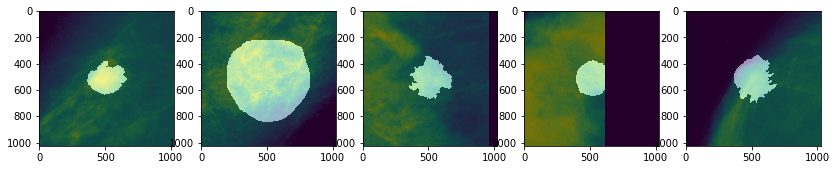

In [5]:
from glob import glob

imgs = glob('../datasets/contours/centered/*.npy')
plt.figure(figsize=(14, 5))

maxp = 5
for ii in range(len(imgs[:maxp])):
    plt.subplot(1, maxp, ii+1)
    mat = np.load(imgs[ii])
    plt.imshow(mat)
    mpath = imgs[ii].replace('.npy', '.jpg')
    plt.imshow(cv2.imread(mpath), alpha=0.5)

plt.show()
plt.close()